In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import unidecode
import random
import string
import matplotlib.pyplot as plt

In [2]:
# load data
data = pd.read_csv('archive/spam.csv', encoding='latin-1')
data = data.iloc[:, :2]
data.columns = ["label", "message"]
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# converting to ascii
data.iloc[:, 1] = data.iloc[:, 1].apply(lambda x: unidecode.unidecode(x))

In [4]:
# ham = 0 and spam = 1
data.iloc[:, 0] = data.iloc[:, 0].apply(lambda x: 0 if x == "ham" else 1)

In [5]:
spams = data[data.iloc[:, 0] == 1]
hams = data[data.iloc[:, 0] == 0]

In [6]:
# creating train and test set
n_test_examples = 50
train_spams = spams.iloc[:-n_test_examples]
train_hams = hams.iloc[:-n_test_examples]

test_spams = spams.iloc[-n_test_examples:]
test_hams = hams.iloc[-n_test_examples:]
test_examples = pd.concat([test_spams, test_hams])

In [7]:
# charset for training
charset = string.printable[:-6]
charset = {char:index for index, char in enumerate(charset)}

In [8]:
def one_hot_char(char):
    v = torch.zeros(1, len(charset))
    v[0][charset[char]] = 1
    return v

def one_hot_word(word):
    return torch.vstack([one_hot_char(char) for char in word if charset.get(char, None) is not None]).reshape((-1,1,len(charset)))

def get_training_example():
    random_class_index = random.randint(0, 1)
    data = train_spams if random_class_index else train_hams
    random_msg_index = random.randint(0, data.shape[0]-1)
    return random_class_index, data.iloc[random_msg_index][1]

In [9]:
class RNN(nn.Module):
    
    def __init__(self, input_size_char_rnn, hidden_size_char_rnn, hidden_size_word_rnn, output_size_word_rnn):
        super().__init__()
        self.hidden_size_char_rnn = hidden_size_char_rnn
        self.hidden_size_word_rnn = hidden_size_word_rnn
        
        self.char_rnn_i2h = nn.Linear(input_size_char_rnn + hidden_size_char_rnn, hidden_size_char_rnn)
    
        input_size_word_rnn = hidden_size_char_rnn
        self.word_rnn_i2h = nn.Linear(input_size_word_rnn + hidden_size_word_rnn, hidden_size_word_rnn)
        self.word_rnn_i2o = nn.Linear(input_size_word_rnn + hidden_size_word_rnn, output_size_word_rnn)
        
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_tensor_word_rnn, hidden_tensor_word_rnn):
        hidden_char_rnn = torch.zeros(1, self.hidden_size_char_rnn)
        
        for char in input_tensor_word_rnn:
            hidden_char_rnn = self.forward_for_char_rnn(char, hidden_char_rnn)
            
        concat_input = torch.cat((hidden_char_rnn, hidden_tensor_word_rnn), dim=1)
            
        hidden_word_rnn = self.word_rnn_i2h(concat_input)
        
        output = self.word_rnn_i2o(concat_input)
        output = self.softmax(output)
        
        return output, hidden_word_rnn
    
    
    def forward_for_char_rnn(self, input_tensor, hidden_tensor):
        concat_input = torch.cat((input_tensor, hidden_tensor), dim=1)

        hidden = self.char_rnn_i2h(concat_input)

        return hidden

In [10]:
input_size_char_rnn = len(charset) 
hidden_size_char_rnn = 256
hidden_size_word_rnn = 384
output_size_word_rnn = 2
learning_rate = 0.0001

In [11]:
rnn = RNN(input_size_char_rnn, hidden_size_char_rnn, hidden_size_word_rnn, output_size_word_rnn)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [12]:
def train(label, msg):

    hidden_word_rnn = torch.zeros(1, hidden_size_word_rnn)

    for word in msg.split(' '):
        if word:
            output, hidden_word_rnn = rnn(one_hot_word(word), hidden_word_rnn)

    loss = loss_fn(output, torch.tensor([label]))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [13]:
def test():
    n_total = test_examples.shape[0]
    n_correct = 0
    with torch.no_grad():
        for i in range(n_total):
            hidden_word_rnn = torch.zeros(1, hidden_size_word_rnn)
            for word in test_examples.iloc[i][1].split(' '):
                if word:
                    output, hidden_word_rnn = rnn(one_hot_word(word), hidden_word_rnn)
            predicted_class = torch.argmax(output).item()
            if predicted_class == test_examples.iloc[i][0]:
                n_correct += 1
    accuracy = n_correct/n_total
    print('Accuracy:', accuracy)
    return accuracy

In [14]:
rolling_loss = 0
all_loses = []
accuracies = [test()]
plot_steps = 200
print_steps = 1000
n_iters = 50000

for i in range(n_iters):
    print(i, end='\r')
    label, msg = get_training_example()
    
    output, loss = train(label, msg)
        
    rolling_loss = (1 - 1/plot_steps) * rolling_loss + (1/plot_steps) * loss
    
    if (i+1) % plot_steps == 0:
        all_loses.append(rolling_loss)
        
    
    if (i+1) % print_steps == 0:
        accuracies.append(test())
        predicted_class = torch.argmax(output).item()
        print(f"{i+1} {(i+1) * 100 / n_iters}% {rolling_loss:.4f} | Original: {label} | Predicted: {predicted_class}")

Accuracy: 0.5
Accuracy: 0.9
1000 2.0 0.3857 | Original: 0 | Predicted: 0
Accuracy: 0.87
2000 4.0 0.2928 | Original: 0 | Predicted: 0
Accuracy: 0.98
3000 6.0 0.2120 | Original: 1 | Predicted: 0
Accuracy: 0.9
4000 8.0 0.1823 | Original: 1 | Predicted: 1
Accuracy: 0.98
5000 10.0 0.1103 | Original: 1 | Predicted: 1
Accuracy: 0.93
6000 12.0 0.1743 | Original: 1 | Predicted: 0
Accuracy: 0.99
7000 14.0 0.1218 | Original: 0 | Predicted: 0
Accuracy: 0.93
8000 16.0 0.1875 | Original: 0 | Predicted: 0
Accuracy: 0.97
9000 18.0 0.0852 | Original: 1 | Predicted: 1
Accuracy: 0.99
10000 20.0 0.1536 | Original: 0 | Predicted: 0
Accuracy: 0.96
11000 22.0 0.1196 | Original: 0 | Predicted: 0
Accuracy: 0.93
12000 24.0 0.1297 | Original: 1 | Predicted: 1
Accuracy: 0.94
13000 26.0 0.1111 | Original: 0 | Predicted: 0
Accuracy: 0.94
14000 28.0 0.0852 | Original: 1 | Predicted: 1
Accuracy: 0.9
15000 30.0 0.0966 | Original: 1 | Predicted: 1
Accuracy: 0.92
16000 32.0 0.0962 | Original: 1 | Predicted: 1
Accuracy: 

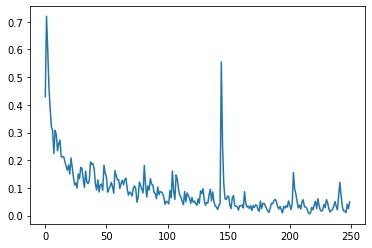

In [15]:
plt.figure()
plt.plot(all_loses)
plt.show()

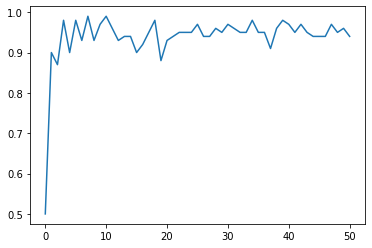

In [16]:
plt.figure()
plt.plot(accuracies)
plt.show()